In [1]:
## ALl plots belong to ED Fig. 10

library(reticulate)
library(anndata)
library(Seurat)
library(dplyr)
library(simspec)
library(Matrix)

library (tidyverse)
sc <- import('scanpy')
source ("Scripts/Filter_Mito_Ribo.R")
path_data = ''
path_fig = '' 

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand()   masks Matrix::expand()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ tidyr::pack()     masks Matrix::pack()
✖ readr::read_csv() masks anndata::read_csv()
✖ tidyr::unpack()   masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


ERROR: Error in eval(expr, envir, enclos): /home/nazbukina/miniconda3/envs/EDA2/lib/libpython3.12.so - /home/nazbukina/miniconda3/envs/EDA2/lib/libpython3.12.so: invalid ELF header


# d9 only

In [11]:
# Importing the individual CC-corrected MiSTR timepoints
splitMR_9d <- readRDS(paste0(path_data, "H9_9d_woCC_processed.rds"))
MR_9d <- readRDS(paste0(path_data, "M9d_woCC_processed.rds"))

Centering and scaling data matrix



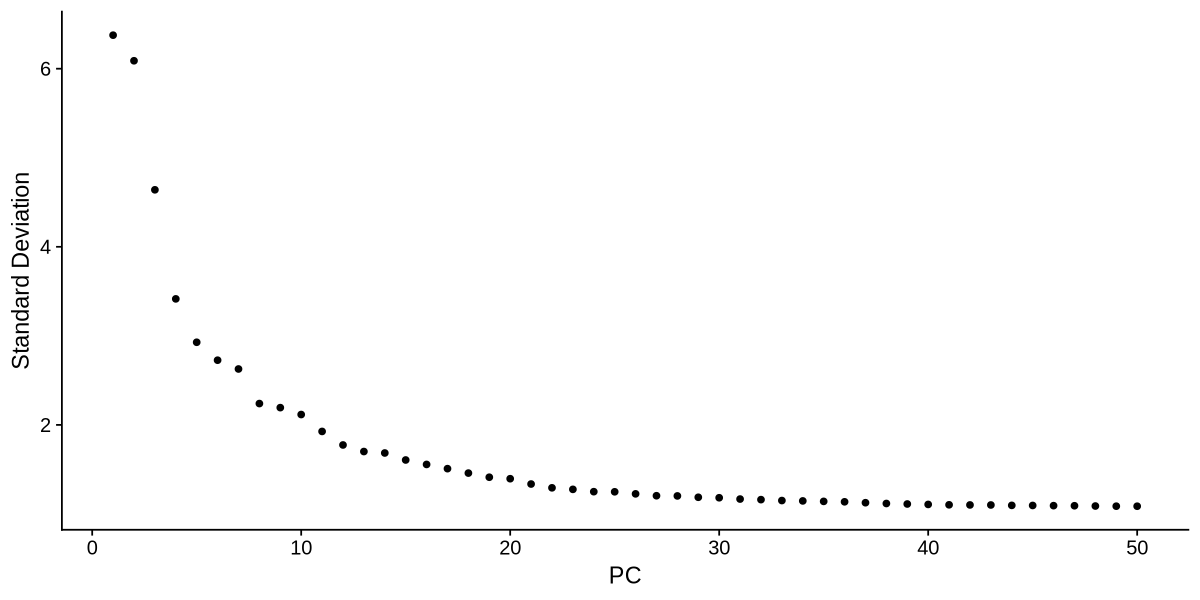

In [32]:
splitMR_9d$orig.ident <- "splitMiSTR"
MR_9d$orig.ident <- "MiSTR"
splitMR_9d$timepoint <- "9d"
MR_9d$timepoint <- "9d"
splitMR_9d$cell_line <- "H9"
MR_9d$cell_line <- "H9"


MiSTR_splitMR_H_noCC <- merge (splitMR_9d, y = c (MR_9d),
                               add.cell.ids = c("splitMR","MiSTR"),
                               project = "M-vs-sM", merge.data = TRUE)

MiSTR_splitMR_H_noCC <- Seurat::NormalizeData (MiSTR_splitMR_H_noCC, verbose = FALSE)
MiSTR_splitMR_H_noCC <- Filter_Mito_Ribo (MiSTR_splitMR_H_noCC)
MiSTR_splitMR_H_noCC <- FindVariableFeatures (MiSTR_splitMR_H_noCC, selection.method = "mean.var.plot")

all.genes <- rownames (MiSTR_splitMR_H_noCC)
MiSTR_splitMR_H_noCC <- ScaleData (MiSTR_splitMR_H_noCC, features = all.genes)

MiSTR_splitMR_H_noCC <- RunPCA (MiSTR_splitMR_H_noCC, pc.genes = ABA_patgenes_all, npcs = 80, verbose = FALSE)
ElbowPlot(MiSTR_splitMR_H_noCC, n=50)

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


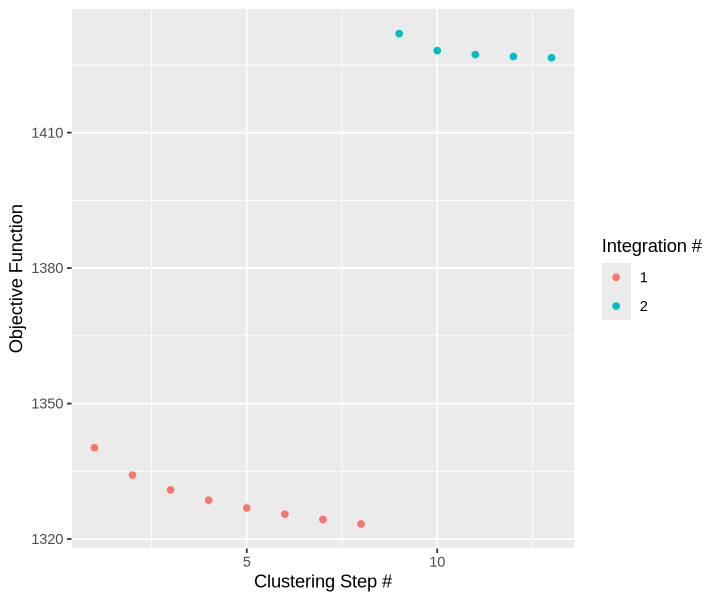

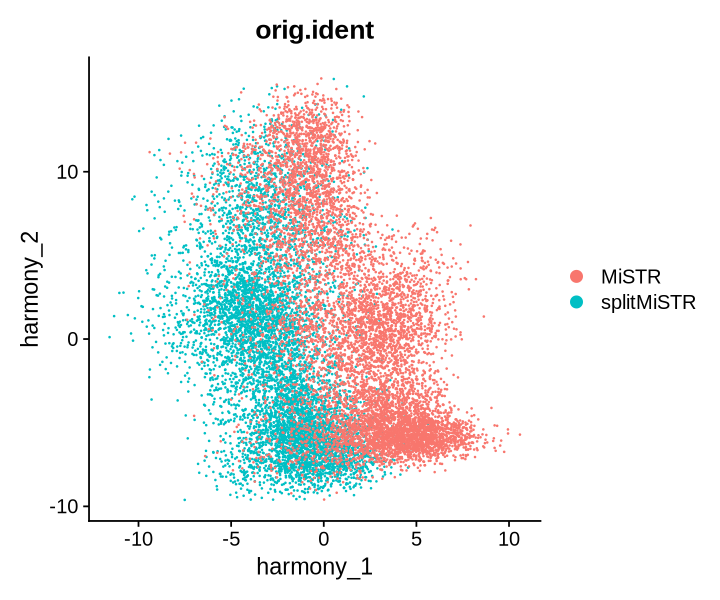

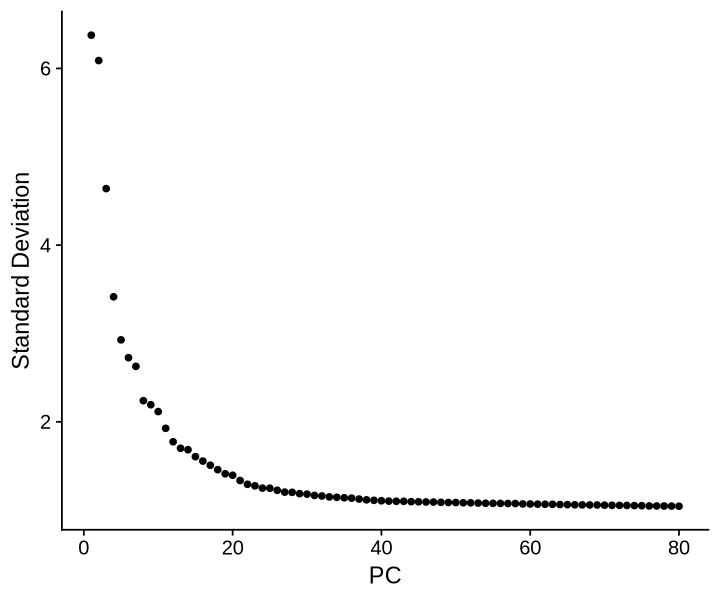

In [33]:
options (repr.plot.height = 5, repr.plot.width = 6)
library(harmony)
MiSTR_splitMR_H_noCC <- RunHarmony (MiSTR_splitMR_H_noCC, "orig.ident", plot_convergence = TRUE)
harmony_embeddings <- Embeddings (MiSTR_splitMR_H_noCC, 'harmony')
DimPlot (object = MiSTR_splitMR_H_noCC, reduction = "harmony", pt.size = .1, group.by = "orig.ident")
ElbowPlot (MiSTR_splitMR_H_noCC, ndims = 80)

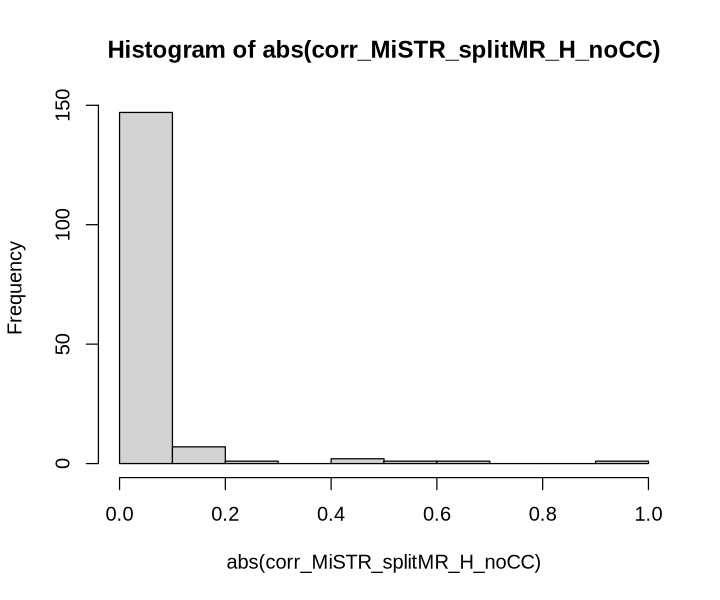

In [35]:
corr_MiSTR_splitMR_H_noCC <- cor (MiSTR_splitMR_H_noCC@meta.data [ , c("S.Score","G2M.Score")], Embeddings (MiSTR_splitMR_H_noCC, "harmony"))
hist(abs(corr_MiSTR_splitMR_H_noCC))
remained_MiSTR_splitMR_H_noCC <- abs(corr_MiSTR_splitMR_H_noCC) < 0.3       
idx_used_pcs_MiSTR_splitMR_H_noCC <- which (colSums(remained_MiSTR_splitMR_H_noCC) == 2)  

In [51]:
MiSTR_splitMR_H_noCC <- MiSTR_splitMR_H_noCC %>% 
    RunUMAP (reduction = "harmony",  dims = intersect (1:25, idx_used_pcs_MiSTR_splitMR_H_noCC)) %>% 
    FindNeighbors (reduction = "harmony", dims = intersect (1:25, idx_used_pcs_MiSTR_splitMR_H_noCC)) %>% 
    FindClusters (resolution = 0.5) %>% 
    identity()

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15205
Number of edges: 436151

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8162
Number of communities: 11
Elapsed time: 1 seconds


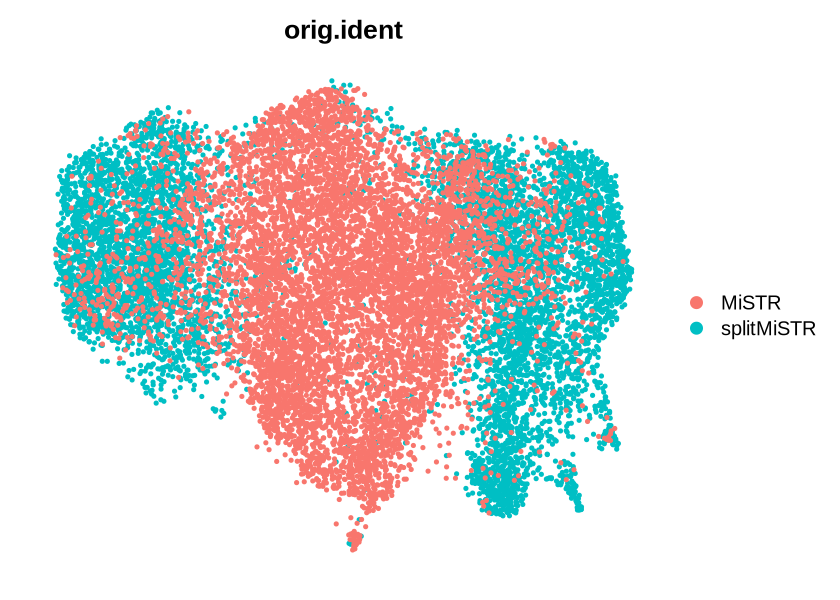

In [100]:
options(repr.plot.height=5, repr.plot.width=7)

DimPlot (df, reduction = "umap", pt.size = 0.8, group.by = "orig.ident")&NoAxes()

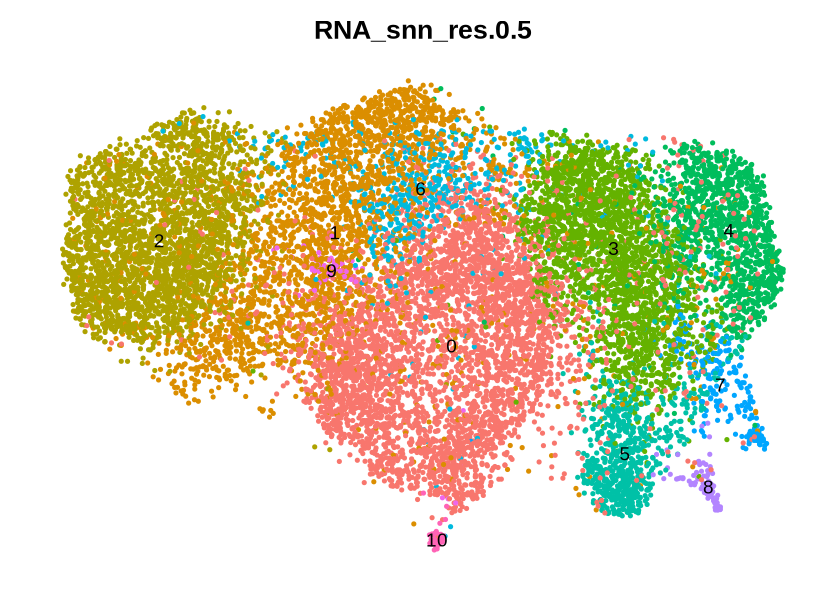

In [99]:
options(repr.plot.height=5, repr.plot.width=7)

DimPlot (df, reduction = "umap", pt.size = 0.8, group.by = "RNA_snn_res.0.5",label = T)&NoAxes()&NoLegend()

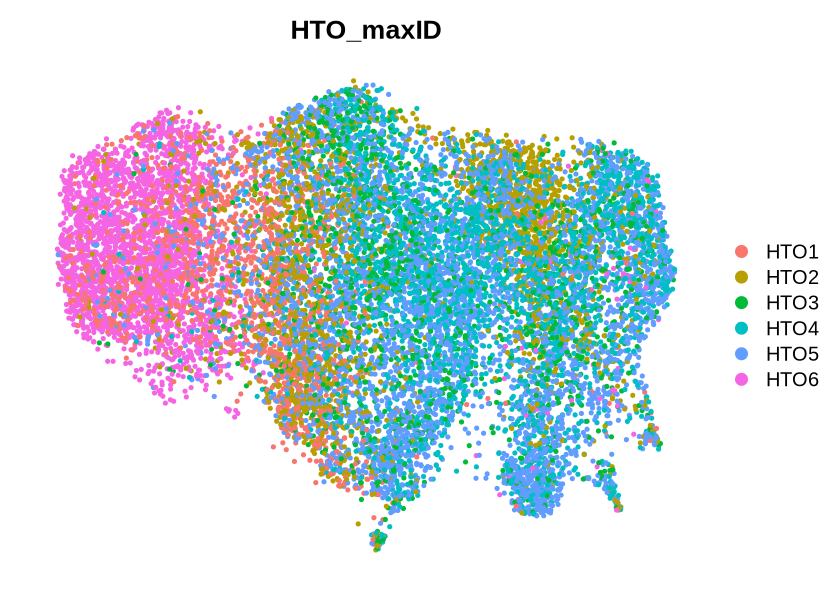

In [98]:
options(repr.plot.height=5, repr.plot.width=7)

DimPlot (df, reduction = "umap", pt.size = 0.8, group.by = "HTO_maxID",label = F)&NoAxes()

## CSS integration

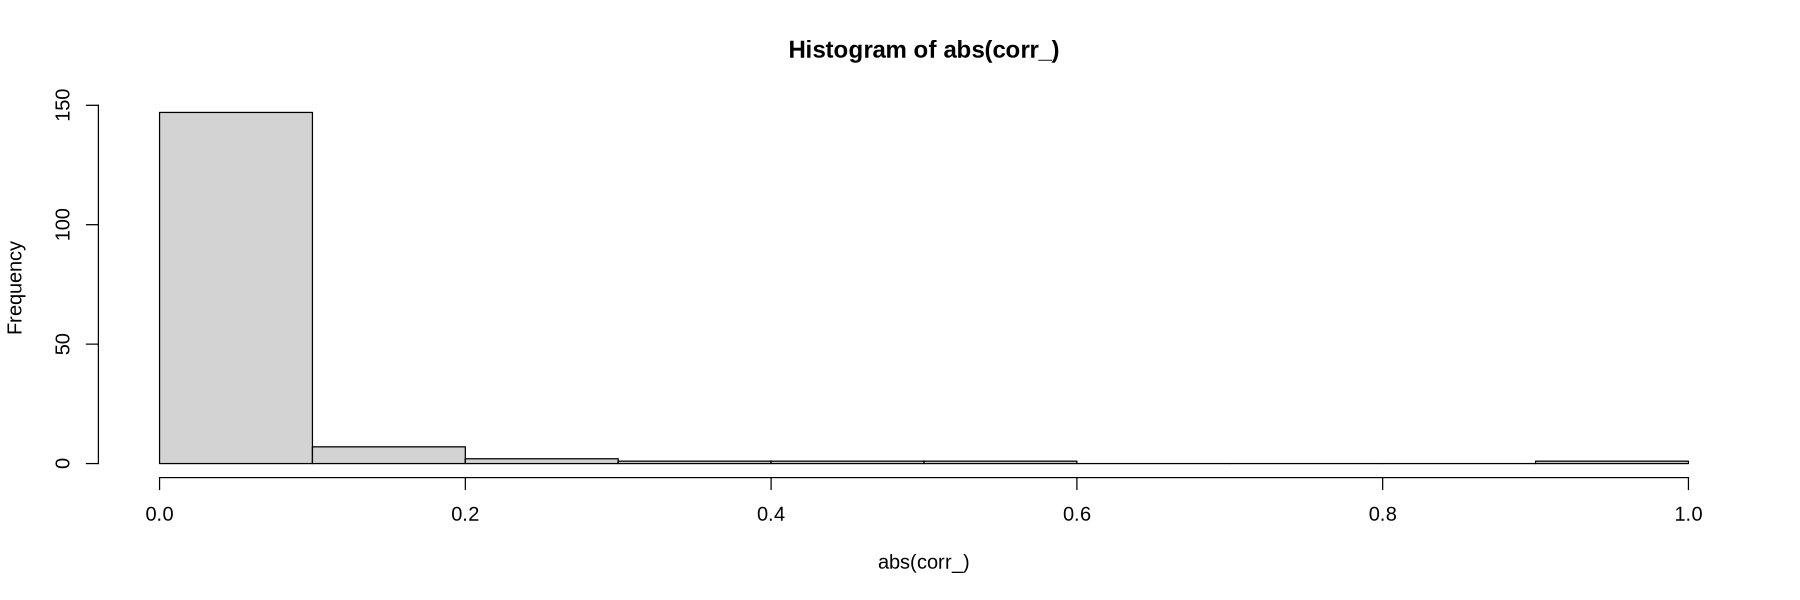

In [109]:
corr_ <- cor (df@meta.data [ , c("S.Score","G2M.Score")], Embeddings (df, "pca"))
hist(abs(corr_))
remained_MiSTR_splitMR_H_noCC <- abs(corr_) < 0.3       
idx_used_pcs_MiSTR_splitMR_H_noCC <- which (colSums(remained_MiSTR_splitMR_H_noCC) == 2)  

In [129]:
df<-df %>%
  cluster_sim_spectrum(label_tag = 'orig.ident', cluster_resolution = 1.5,
                       reduction.name = 'css_', reduction.key='CSSRNA_', num_pcs_use=20) 

df<-df %>% 
          RunUMAP (reduction = "css_",  dims = 1:10,reduction.name = "umap_rna_css") 

Start to do clustering for each sample...

  Done clustering of sample MiSTR.

  Done clustering of sample splitMiSTR.

Finished clustering.

Calculating average profiles of clusters...

Calculating standardized similarities to clusters...

Doing z-transformation...

Done. Returning results...

11:23:48 UMAP embedding parameters a = 0.9922 b = 1.112

11:23:48 Read 15161 rows and found 10 numeric columns

11:23:48 Using Annoy for neighbor search, n_neighbors = 30

11:23:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:23:49 Writing NN index file to temp file /tmp/RtmpCQkXPJ/file669af4acf310c

11:23:49 Searching Annoy index using 1 thread, search_k = 3000

11:23:54 Annoy recall = 100%

11:23:55 Commencing smooth kNN distance calibration using 1 thread
 with target n

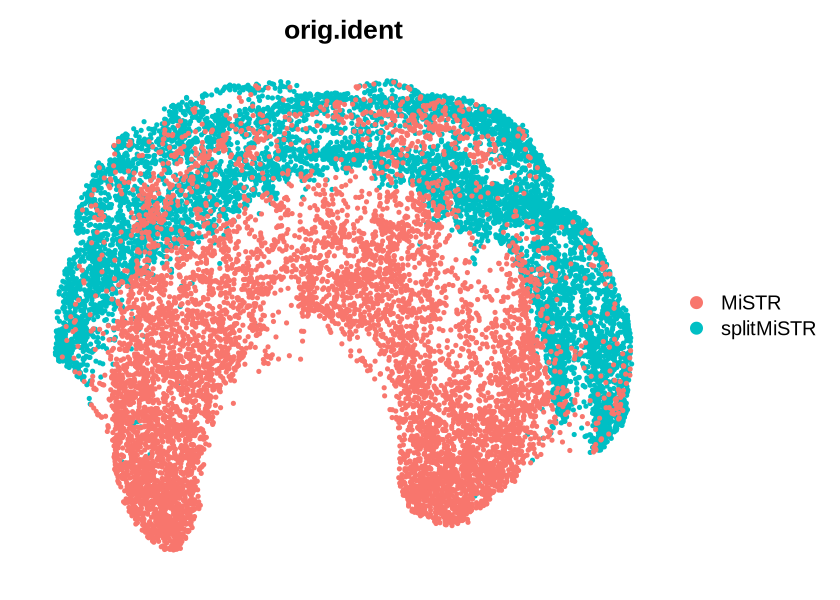

In [130]:
options(repr.plot.height=5, repr.plot.width=7)
DimPlot (df, reduction = "umap_rna_css", pt.size = 0.8, group.by = "orig.ident")&NoAxes()

## CCA

In [239]:
splitMR_9d <- readRDS (paste0(path_data, "H9_9d_woCC_processed.rds"))
MR_9d <- readRDS (paste0(path_data,"M9d_woCC_processed.rds"))
splitMR_9d <- NormalizeData(splitMR_9d) %>% FindVariableFeatures(nfeatures = 3000)
MR_9d <- NormalizeData(MR_9d) %>% FindVariableFeatures(nfeatures = 3000)
splitMR_9d$orig.ident <- "splitMiSTR"
MR_9d$orig.ident <- "MiSTR"
seurat_objs <- list(DS1 = splitMR_9d, DS2 = MR_9d)
anchors <- FindIntegrationAnchors(object.list = seurat_objs, dims = 1:30, reduction = "cca")

seurat <- IntegrateData(anchors, dims = 1:30)

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21660 anchors

Filtering anchors

	Retained 4042 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



Centering and scaling data matrix

PC_ 1 
Positive:  FTL, IGFBP3, BST2, DDIT4, UNG, MCM6, CCND2, IGFBP5, MCM5, ABCA5 
	   IFITM3, MIAT, RGS16, NNAT, SMOC1, IGFBP2, ACTG1, APOE, MCM4, MSH6 
	   MAPK10, PMEL, FRRS1L, GINS2, BTG2, WDR76, L1TD1, SAT1, KRT19, COL1A2 
Negative:  TOP2A, UBE2C, CENPF, NUSAP1, TPX2, DLGAP5, TUBB4B, ASPM, CCNB1, HMGB2 
	   MKI67, KPNA2, CDK1, PTTG1, BIRC5, UBE2S, SGO2, CCNA2, CDC20, CENPA 
	   PLK1, AURKA, CKS1B, GTSE1, CDCA8, CKS2, NUF2, CDCA3, H2AFX, HMMR 
PC_ 2 
Positive:  TYMS, PCLAF, DUT, HELLS, CLSPN, PCNA, MCM3, GINS2, DHFR, HES4 
	   DTL, SUPT16H, RRM1, CDC6, FABP5, MYBL2, MCM4, FEN1, FAM111B, UNG 
	   ORC6, ATAD2, DNMT1, NCL, UHRF1, RRM2, CHAF1A, MCM10, SLBP, FANCI 
Negative:  STMN1, TUBA1C, SOX11, CDKN1C, CDC20, SOX4, LGALS1, ARL6IP1, CCNB2, PLK1 
	   SIX6, DDIT4, PIF1, HES1, H3F3B, LDHA, CENPA, KCNQ1OT1, PTTG1, IGFBP5 
	   PAX2, UBB, BNIP3, KNSTRN, SIX3, H1F0, AURKA, NNAT, FJX1, GAS2L3 
PC_ 3 
Positive:  TMSB4X, CTGF, WLS, C1orf61, NR2F1, ID4, CDH2, C

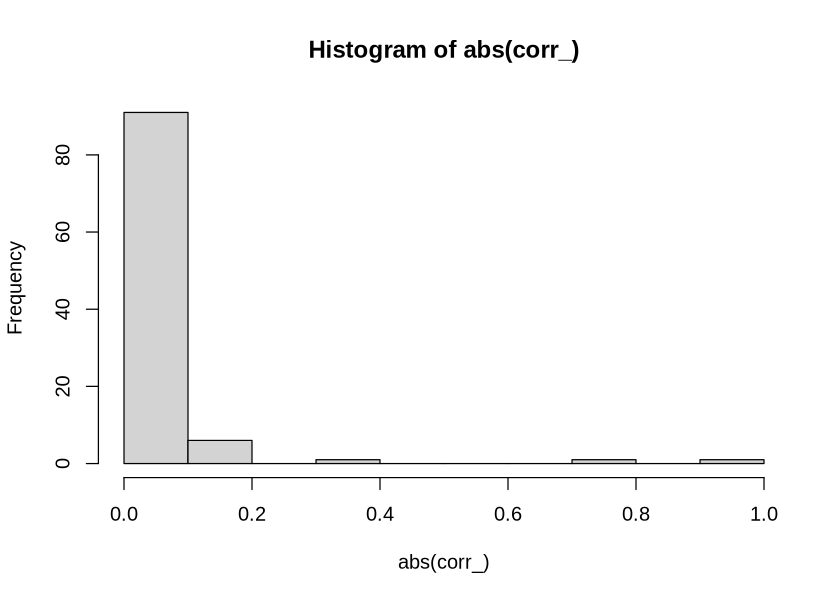

In [240]:
seurat <- ScaleData(seurat)
seurat <- RunPCA(seurat, npcs = 50)
corr_ <- cor (seurat@meta.data [ , c("S.Score","G2M.Score")], Embeddings (seurat <- RunUMAP(seurat, dims = 1:20), "pca"))
hist(abs(corr_))

In [241]:
remained_MiSTR_splitMR_H_noCC <- abs(corr_) < 0.3       

idx_used_pcs_MiSTR_splitMR_H_noCC <- which (colSums(remained_MiSTR_splitMR_H_noCC) == 2)  
seurat <- seurat %>% 
    RunUMAP (reduction = "pca",  dims = intersect (1:25, idx_used_pcs_MiSTR_splitMR_H_noCC)) 


15:55:51 UMAP embedding parameters a = 0.9922 b = 1.112

15:55:51 Read 15205 rows and found 22 numeric columns

15:55:51 Using Annoy for neighbor search, n_neighbors = 30

15:55:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:55:52 Writing NN index file to temp file /tmp/RtmpCQkXPJ/file669af67114142

15:55:52 Searching Annoy index using 1 thread, search_k = 3000

15:55:57 Annoy recall = 100%

15:55:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:55:58 Initializing from normalized Laplacian + noise (using irlba)

15:56:00 Commencing optimization for 200 epochs, with 622448 positive edges

15:56:07 Optimization finished



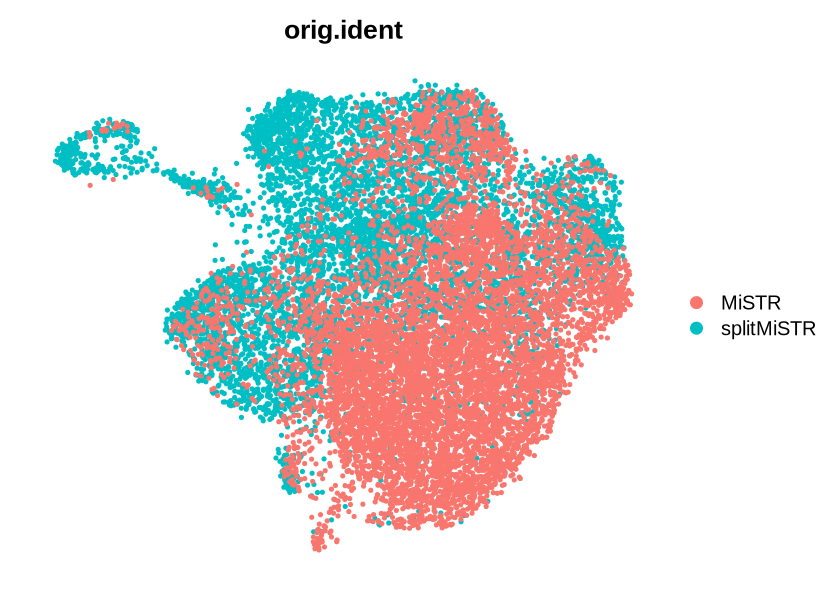

In [243]:
options(repr.plot.height=5, repr.plot.width=7)

DimPlot (seurat, reduction = "umap", pt.size = 0.8, group.by = "orig.ident")&NoAxes()
saveRDS(seurat, paste0(path_fig,"d9_mistr_cca.rds"))

# Plots

In [164]:
df<- df %>%
  subset (hash.ID != "Negative") %>%
  subset (hash.ID != "Doublet") %>%
  subset (hash.ID != "NA")


hashcol_new <- c("A"="#007EDE",
                 "B" = "#00A4DB",
                 "C" = "#FFCC74",
                 "D" = "#F9A600",
                 "E" =  "#E48000",
                 "Control" = "#00477D")


new.metadata <- as.tibble (df@meta.data) %>% 
  mutate (Condition = as.character (case_when (hash.ID == "HTO1" ~ "A",
                                               hash.ID == "HTO2" ~ "B",
                                               hash.ID == "HTO3" ~ "C",
                                               hash.ID == "HTO4" ~ "D",
                                               hash.ID == "HTO5" ~ "E",
                                                hash.ID == "HTO6" ~ "Control",
                                               hash.ID == "Doublet" ~ "Doublet",
                                               hash.ID == "Negative" ~ "Negative",
                                              )))

# Assign the new.metadata info for "HTO_classification", appended as a character to the Seurat metadata
df$Condition <- new.metadata$Condition
df$Condition<- factor(df$Condition, levels=c("Control", "A", "B", "C", "D", "E"))

setwd (path_fig)
png ("UMAP_hashtag_hashID_split-clean_9d.png", width=16,height=12, units="cm",res=500)

DimPlot (df, reduction = "umap", pt.size = 0.6, group.by = "Condition", 
         cols = hashcol_new)+NoAxes()+NoLegend()
dev.off ()

pdf("UMAP_hashtag_hashID_split-clean_9d.pdf", width=20,height=12)

DimPlot (df, reduction = "umap", pt.size = 0.6, group.by = "Condition", 
         cols = hashcol_new)+NoAxes()
dev.off ()

png 
  2

png 
  2

In [151]:

origin <- sort(unique(df$RNA_snn_res.0.5))

# Define the corresponding cell types
cell_types <- c(
  "Ventral Neuroepithelium",
  "Cortical-PSB-LGE Progenitors",
  "Cortical-PSB-LGE Progenitors",
  "Hypothalamic Progenitors",
  "Hypothalamic Progenitors",
  "Floor Plate",
  "Ventral Tele-, Diencephalon Progenitors",
  "Ventral Neuroblasts",
  "Hypothalamic Neurons",
  "Cortical-PSB-LGE Progenitors",
  "Undetermined"
)

# Create a data frame mapping RNA_snn_res.1 to neurons_name
dflab <- data.frame(
  RNA_snn_res.0.5 = origin,
  seurat_cluster_annotation = cell_types
)

dflab

RNA_snn_res.0.5,seurat_cluster_annotation
<fct>,<chr>
0,Ventral Neuroepithelium
1,Cortical-PSB-LGE Progenitors
2,Cortical-PSB-LGE Progenitors
3,Hypothalamic Progenitors
4,Hypothalamic Progenitors
5,Floor Plate
6,"Ventral Tele-, Diencephalon Progenitors"
7,Ventral Neuroblasts
8,Hypothalamic Neurons


In [152]:
df <- AddMetaData(df, dflab$seurat_cluster_annotation[match(df$RNA_snn_res.0.5, dflab$RNA_snn_res.0.5)], col.name = "seurat_cluster_annotation")

In [168]:
cell_types_cols <- c(
  "Ventral Neuroepithelium" = '#EF7E06',
  "Cortical-PSB-LGE Progenitors" = '#3553AA',
  "Hypothalamic Progenitors" = '#DC284F',
  "Floor Plate" = '#8E2786',
  "Ventral Tele-, Diencephalon Progenitors"= '#219A8A',
  "Ventral Neuroblasts"= '#C65976',
  "Hypothalamic Neurons"='#EB849A',
  "Undetermined"='#959595'
)

setwd (path_fig)
png ("UMAP_9d_annotation.png", width=16,height=12, units="cm",res=500)
DimPlot (df, reduction = "umap", pt.size = 0.6, group.by = "seurat_cluster_annotation", 
         cols = cell_types_cols)+NoAxes()+NoLegend()
dev.off ()

png 
  2

In [163]:
orig_cols <- c('splitMiSTR'='#FCAA67', 'MiSTR'='#6F4C4C')
setwd (path_fig)
png ("UMAP_9d_org_mistr.png", width=16,height=12, units="cm",res=500)

DimPlot (df, reduction = "umap", pt.size = 0.6, group.by = "orig.ident", 
         cols = orig_cols)+NoAxes()+NoLegend()
dev.off ()

png 
  2

In [202]:
# Cells per hashtag in each cluster
Monly <- df %>% 
  subset (orig.ident == "MiSTR")
Monly <- as.data.frame (table (Monly$seurat_cluster_annotation, Monly$Condition))

# Rename columns
names(Monly)[1] <- "Cluster"
names(Monly)[2] <- "Condition"
Monly = Monly[Monly$Condition!='Control',]

# Calculating total cells per Condition
Monly_summary <- Monly %>% 
  subset (Condition != "Doublet") %>% 
  subset (Condition != "Negative") %>% 
  dplyr::group_by (Condition) %>% 
  dplyr::summarise (total = sum (Freq))

# Adding the total cell counts to calculate the proportions of cells per cluster in each Condition
Monly <- merge (Monly, Monly_summary) %>% 
  mutate (prop_cells_per_cluster = ((Freq/total)*100))

Monly$Condition <- factor(Monly$Condition, levels = rev(c("A", "B", "C", "D", "E")))
Monly$Cluster <- factor(Monly$Cluster, levels = c('Ventral Tele-, Diencephalon Progenitors','Cortical-PSB-LGE Progenitors',
                                                  'Ventral Neuroepithelium', 'Hypothalamic Progenitors',
                                                  'Ventral Neuroblasts','Hypothalamic Neurons','Floor Plate','Undetermined'))


setwd (path_fig)
# STACKED BAR PLOT
pdf("Barplot_seurat_clusters_per_hashtag_MiSTR.pdf",width=10,height=5)
Monly %>% 
    ggplot (aes (y = Condition, x = prop_cells_per_cluster, fill = Cluster)) +
    geom_bar (stat = "identity", aes (stat = "fill")) +
    scale_fill_manual (values=cell_types_cols) +
    theme_classic () +
    theme (axis.text.x = element_text ( size = 8))
dev.off ()

Warning message in geom_bar(stat = "identity", aes(stat = "fill")):
“Ignoring unknown aesthetics: stat”


png 
  2

In [196]:
unique(df$seurat_cluster_annotation)

[1] "Hypothalamic Progenitors"               
[2] "Cortical-PSB-LGE Progenitors"           
[3] "Floor Plate"                            
[4] "Ventral Neuroepithelium"                
[5] "Ventral Neuroblasts"                    
[6] "Hypothalamic Neurons"                   
[7] "Ventral Tele-, Diencephalon Progenitors"
[8] "Undetermined"

In [201]:

# Cells per hashtag in each cluster
Monly <- df %>% 
    subset (orig.ident == "splitMiSTR")
Monly <- as.data.frame (table (Monly$seurat_cluster_annotation, Monly$Condition))

# Rename columns
names(Monly)[1] <- "Cluster"
names(Monly)[2] <- "Condition"
#Monly = Monly[Monly$Condition!='Control',]

# Calculating total cells per Condition
Monly_summary <- Monly %>% 
  subset (Condition != "Doublet") %>% 
  subset (Condition != "Negative") %>% 
  dplyr::group_by (Condition) %>% 
  dplyr::summarise (total = sum (Freq))

# Adding the total cell counts to calculate the proportions of cells per cluster in each Condition
Monly <- merge (Monly, Monly_summary) %>% 
  mutate (prop_cells_per_cluster = ((Freq/total)*100))


Monly$Cluster <- factor(Monly$Cluster, levels = c('Ventral Tele-, Diencephalon Progenitors','Cortical-PSB-LGE Progenitors',
                                                  'Ventral Neuroepithelium', 'Hypothalamic Progenitors',
                                                  'Ventral Neuroblasts','Hypothalamic Neurons','Floor Plate','Undetermined'))
Monly$Condition <- factor(Monly$Condition, levels = rev(c( "Control","A", "B", "C", "D", "E")))

setwd (path_fig)
# STACKED BAR PLOT
pdf("Barplot_seurat_clusters_per_hashtag_splitMiSTR.pdf",width=10,height=5)
Monly %>% 
  ggplot (aes (y = Condition, x = prop_cells_per_cluster, fill = Cluster)) +
    geom_bar (stat = "identity", aes (stat = "fill")) +
    scale_fill_manual (values=cell_types_cols) +
    theme_classic () +
    theme (axis.text.x = element_text ( size = 8))
dev.off ()

Warning message in geom_bar(stat = "identity", aes(stat = "fill")):
“Ignoring unknown aesthetics: stat”


png 
  2

# marker genes

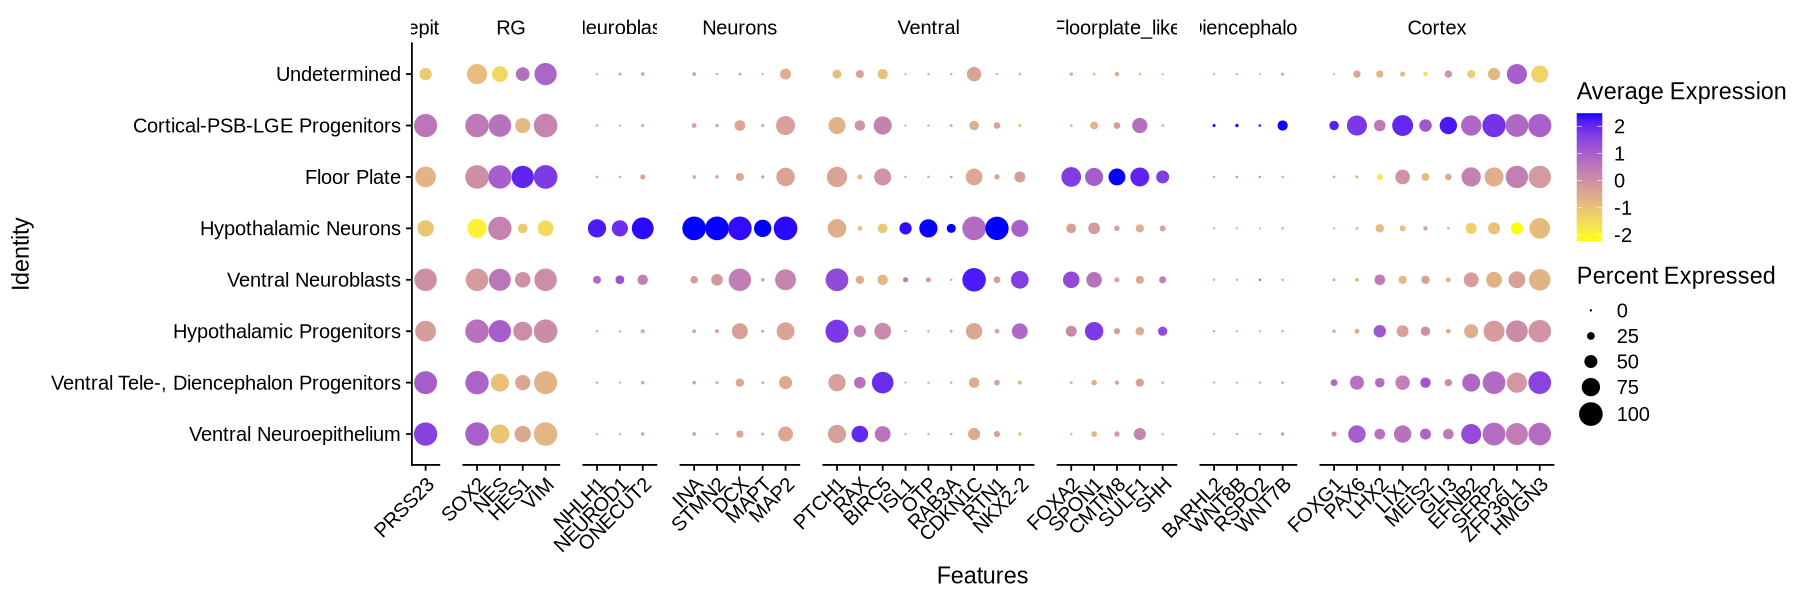

In [231]:
options(repr.plot.height=5, repr.plot.width=15)
df$seurat_cluster_annotation <- factor(df$seurat_cluster_annotation, levels = c('Ventral Neuroepithelium', 
                                                                                'Ventral Tele-, Diencephalon Progenitors',
                                                                                  'Hypothalamic Progenitors',
                                                                                  'Ventral Neuroblasts','Hypothalamic Neurons',
                                                                                  'Floor Plate','Cortical-PSB-LGE Progenitors','Undetermined'))

Idents(df)<-"seurat_cluster_annotation"
cell_types <- list(
  "Neuroepithelium" = c("PRSS23"),
  "RG" = c("SOX2", "NES", "HES1", "VIM"),
  "Neuroblast" = c("NHLH1", "NEUROD1", "ONECUT2"),
  "Neurons" = c("INA", "STMN2", "DCX", "MAPT", "MAP2"),
  "Ventral" = c("PTCH1", "RAX", "BIRC5", "ISL1", "OTP", "RAB3A", "CDKN1C", "RTN1", "NKX2-2"),
  "Floorplate_like" = c("FOXA2",  "SPON1", "CMTM8", "SULF1","SHH"),
  "Diencephalon" = c("BARHL2", "WNT8B", "RSPO2", "WNT7B"),
  "Cortex" = c('FOXG1',
    "PAX6", 
    "LHX2", 
    "LIX1", 
    "MEIS2", 
    "GLI3", 
    "EFNB2", 
    "SFRP2", 
    "ZFP36L1", 
    "HMGN3")
)


DotPlot(df,  features =cell_types, 
        cols= c("yellow", "blue")
        )+ RotatedAxis()

ggsave(paste0 ("Marker_genes.pdf"), width = 15, height = 6)

# Integration plots

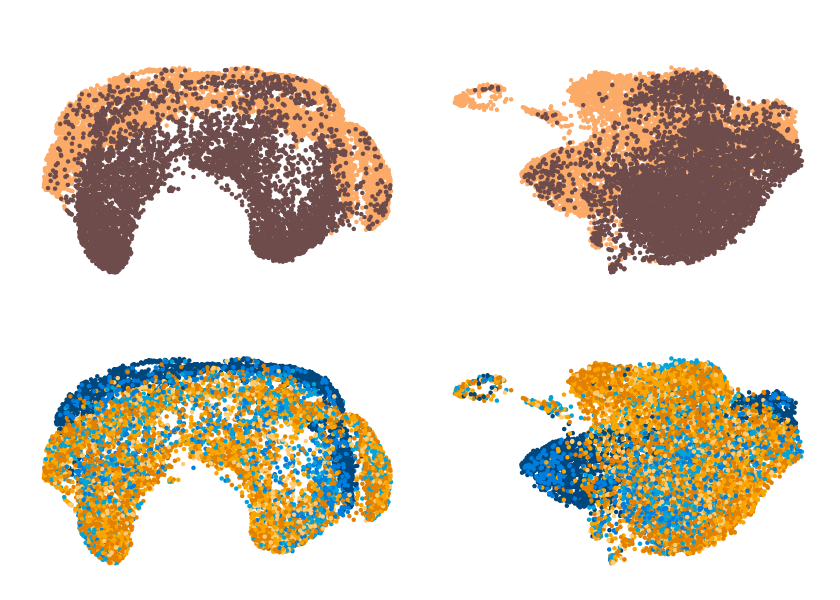

In [247]:
p1<-DimPlot (df, reduction = "umap_rna_css", pt.size = 0.6, group.by = "orig.ident", 
         cols = orig_cols)+NoAxes()+NoLegend()+ ggtitle('')

p2<-DimPlot (df, reduction = "umap_rna_css", pt.size = 0.6, group.by = "Condition", 
         cols = hashcol_new)+NoAxes()+NoLegend()+ ggtitle('')




seurat<- seurat %>%
  subset (hash.ID != "Negative") %>%
  subset (hash.ID != "Doublet") %>%
  subset (hash.ID != "NA")


new.metadata <- as.tibble (seurat@meta.data) %>% 
  mutate (Condition = as.character (case_when (hash.ID == "HTO1" ~ "A",
                                               hash.ID == "HTO2" ~ "B",
                                               hash.ID == "HTO3" ~ "C",
                                               hash.ID == "HTO4" ~ "D",
                                               hash.ID == "HTO5" ~ "E",
                                                hash.ID == "HTO6" ~ "Control",
                                               hash.ID == "Doublet" ~ "Doublet",
                                               hash.ID == "Negative" ~ "Negative",
                                              )))

seurat$Condition <- new.metadata$Condition



p3<-DimPlot (seurat, reduction = "umap", pt.size = 0.6, group.by = "orig.ident", 
         cols = orig_cols)+NoAxes()+NoLegend()+ ggtitle('')

p4<-DimPlot (seurat, reduction = "umap", pt.size = 0.6, group.by = "Condition", 
         cols = hashcol_new)+NoAxes()+NoLegend()+ ggtitle('')

(p1+p3)/(p2+p4)
ggsave(paste0 ("Integration.png"), width = 12, height = 9, dpi=500)

# DV

In [249]:
unique(df$seurat_cluster_annotation)

[1] Hypothalamic Progenitors               
[2] Cortical-PSB-LGE Progenitors           
[3] Floor Plate                            
[4] Ventral Neuroepithelium                
[5] Ventral Neuroblasts                    
[6] Hypothalamic Neurons                   
[7] Ventral Tele-, Diencephalon Progenitors
[8] Undetermined                           
8 Levels: Ventral Neuroepithelium ... Undetermined

In [248]:
library (Seurat)
library (tidyverse)
library (plyr)
library (ggforce)
library (ggridges)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:purrr’:

    compact


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




In [258]:
df<-readRDS(paste0(path_data,  "d9_mistr_v2.rds"))

DVprogs <- df %>% 
  subset (seurat_cluster_annotation %in% c("Hypothalamic Progenitors", "Cortical-PSB-LGE Progenitors", 
                                           "Ventral Neuroepithelium", "Ventral Tele-, Diencephalon Progenitors")) 

# Make the original identity be in the right order
DVprogs$orig.ident <- factor (DVprogs$orig.ident, levels = c ("splitMiSTR", "MiSTR"))

# Normalization not needed
# DVprogs <- Seurat::NormalizeData (DVprogs, verbose = FALSE)

DVprogs <- Filter_Mito_Ribo (DVprogs)

# vst is the new method from Seurat v4 - gives back around 1000-2000 genes (mean.var.plot is the old method and gives less)
DVprogs <- FindVariableFeatures (DVprogs, selection.method = "vst") 

# Scaling is needed in all subsetting events
all.genes <- rownames (DVprogs)
DVprogs <- ScaleData (DVprogs, features = all.genes)

###################################################################################################
######################### Extracting a list of relevant DV patterning genes #######################
###################################################################################################

# List of genes varying in the D-V axis (based on the dataset variation and literature)
DVgenes <- c("PAX6", "GDF7", "GLI3", "PAX7", "WNT3A", "SOX10", "SIX6", "NKX2-1", "FOXA1", "FOXA2", "SHH", "NKX6-1",
             "DLX1", "DLX2", "DLX5", "DLX6", "NKX2-1", "DBX1", "NKX6-2", "HMX3", "PROX1", "NR2F2",
             "FOXG1", "PAX6", "EMX2",
             "FGF17", "TFAP2C", "DMRTA2",        # PSB
             "GSX2", "DLX1", "DLX2", "OLIG2",    # GE
             "ZNF503", "FOXP1", "SP8", "ZFHX3",  # LGE
             "NKX2-1",                           # MGE
             "SIX6",                             # PoA
             "NKX2-2", "RAX", "PROX1",           # hTH
             "SHH", "FGF8")

# 1) Extracting the expression matrix for Variable Feature genes and DVgenes expressed in the dataset
expr <- DVprogs[['RNA']]@data[union(DVgenes, VariableFeatures (DVprogs)), ]
# 2) Creating a Seurat object where the rows are the cells and the columns are genes
srt <- CreateSeuratObject (t(expr))
# 3) Processing the gene Seurat object to find the nearest neighbor genes
srt <- srt %>% 
  ScaleData () %>% 
  # We set a lower number of PCs to calculate than in normal analysis cause we have less cells than genes 
  RunPCA (npcs = 20, features = rownames(srt)) %>% 
  # We need to set a reasonable K number to not have too many neighbours for each gene
  FindNeighbors (k.param = 10)


# Here we make the matrix symmetric and turn it into a summary dataframe with three-columns showing the values(x, always 1) of the non-zero row(i)-column(j) pairs 
df <- summary (srt[['RNA_nn']] | t(srt[['RNA_nn']]))
# In this df, we get 10 NN genes per gene in "j"

# Now we turn the gene indices to the actual gene names
df$i <- colnames(srt)[df$i] # colnames here are gene names
df$j <- colnames(srt)[df$j] # colnames here are gene names
# Now the df shows gene names

# Setting the seed genes from Dorsal and Ventral regions to get their nearest neighbours (coexpressed/covarying genes)
DG <- c("PAX6","GLI3","EMX2","GAS1","LRRN1","EMX1","SP8","FEZF2","RPRM")
VG <- c("NKX2-1","NKX2-2","SIX6","SHH","PROX1","FGF8")

# Retrieve the NN genes 

DG_exp <- sort(unique(df$i[df$j %in% DG]))
VG_exp <- sort(unique(df$j[df$i %in% VG]))


Centering and scaling data matrix

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

PC_ 1 
Positive:  MiSTR-GGAATCTCAAGTATCC, MiSTR-GAAGAATGTAACCCTA, MiSTR-CCTTGTGAGCCATTTG, MiSTR-AGTCTCCAGTCTTGGT, MiSTR-GTGCTGGCATCACGGC, MiSTR-TGCGATAAGACTCATC, MiSTR-TACCGAACAGAATCGG, MiSTR-CCGGTGAGTGTCTCCT, MiSTR-GAGTTTGGTCACTCGG, MiSTR-CGGTCAGAGATGGTCG 
	   MiSTR-TGAGCATAGCGGATCA, MiSTR-AGAAGTAAGAAGCGAA, MiSTR-GCAGGCTTCAGCAATC, splitMR-CCACACTGTTGTGGAG, splitMR-GAGGCCTCACCCTATC, splitMR-CCGGTGACACAATCTG, MiSTR-CATCAAGGTGTCACAT, MiSTR-AAGACAACATCGTGCG, MiSTR-AGCTTCCGTTCTCCAC, splitMR-CTGAATGGTAGAGATT 
	   MiSTR-TCTACCGGTCTGTCAA, splitMR-TAACACGCATTGTACG, MiSTR-TATGTTCTCTTCTGTA, MiSTR-TTGGGTAAGCGTGAAC, MiSTR-AGACCATAGGACTAAT, MiSTR-ATAGGCTGTAGGTCAG, splitMR-AATGGAAAGTTGAAGT, MiSTR-GCTGAATGTCTCCTGT, splitMR-GACCGTGTCATGCATG, MiSTR-CTCAAGAAGGAACATT 
Negative:  splitMR-AAGACTCCACCCAAGC, MiSTR-TTCCTTCCATGCACTA, splitMR-AAGGAATAG

In [259]:
DVprogs <- AddModuleScore (DVprogs, features = list(DG_exp, VG_exp), name = c("D_score", "V_score")) # Remember that at number is added after each column name

# DV_score will be a new metadata column with the difference between "D_score" and "V_score"
DVprogs$DV_score <- DVprogs$D_score1 - DVprogs$V_score2

# DV_rank will be a new metadata column where we rank the cells by their DV_score
DVprogs$DV_rank <- rank (DVprogs$DV_score)


In [260]:
pdf ("RidgePlot_DV_rank_origIdent.pdf",width=7,height=6)
margin (2,2,2,2, unit = "pt")
ggplot (DVprogs@meta.data, aes (x = DV_rank, y = orig.ident, fill = orig.ident)) +
  geom_density_ridges (scale = 0.5, size = 0.5) +
  scale_fill_manual (values = orig_cols) + 
  theme_classic() +
  theme(
    panel.background = element_rect(fill='transparent'),
    plot.background = element_rect(fill='transparent', color=NA),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    legend.background = element_rect(fill='transparent'),
    legend.box.background = element_rect(fill='transparent')
  )
dev.off()

[1] 2points 2points 2points 2points

Warning message in geom_density_ridges(scale = 0.5, size = 0.5):
“Ignoring unknown parameters: `size`”
Picking joint bandwidth of 494



png 
  2

In [262]:
pdf ("JitterPlot_DV_rank_merged_cluster_annotation.pdf",width=10,height=4)
ggplot (DVprogs@meta.data, aes (x = DV_rank, y = orig.ident, fill = seurat_cluster_annotation)) +
  geom_jitter (aes (fill = seurat_cluster_annotation), shape = 21, alpha = 1, size = 1.3, stroke = 0) +
  scale_fill_manual (values = cell_types_cols) +
  theme_classic() +
  theme(panel.background = element_rect(fill='transparent'),
        plot.background = element_rect(fill='transparent', color=NA),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.background = element_rect(fill='transparent'),
        legend.box.background = element_rect(fill='transparent'))
dev.off()

png 
  2

In [268]:
DVprogs$Condition <- factor(DVprogs$Condition, levels = rev(c( "Control","A", "B", "C", "D", "E")))

pdf ("JitterPlot_DV_rank_MiSTR_Condition.pdf",width=10,height=2.5)
DVprogs@meta.data %>% 
  subset ((orig.ident == "MiSTR") & (Condition != "Doublet") & (Condition != "Negative")) %>% 
    ggplot (aes (x = DV_rank, y = Condition, fill = Condition)) +
      geom_jitter (aes (fill = Condition), shape = 21, alpha = 1, size = 1, stroke = 0, height = 0.1) +
      scale_fill_manual (values = hashcol_new) +
      theme_classic() +
      theme (panel.background = element_rect(fill='transparent'),
            plot.background = element_rect(fill='transparent', color=NA),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.background = element_rect(fill='transparent'),
            legend.box.background = element_rect(fill='transparent')) +
    stat_summary (aes(x = DV_rank,
                     y = Condition,
                     color = Condition), 
                 fun = median,
                 width = 0.5,
                 geom = "crossbar") +
scale_color_manual (values = hashcol_new)
dev.off()

png 
  2

In [269]:
pdf ("JitterPlot_DV_rank_splitMiSTR_Condition.pdf",width=10,height=3)
DVprogs@meta.data %>% 
  subset ((orig.ident == "splitMiSTR") & (Condition != "Doublet") & (Condition != "Negative")) %>% 
  ggplot (aes (x = DV_rank, y = Condition, fill = Condition)) +
  geom_jitter (aes (fill = Condition), shape = 21, alpha = 1, size = 1, stroke = 0, height = 0.1) +
  scale_fill_manual (values = hashcol_new) +
  theme_classic() +
  theme (panel.background = element_rect(fill='transparent'),
         plot.background = element_rect(fill='transparent', color=NA),
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(),
         legend.background = element_rect(fill='transparent'),
         legend.box.background = element_rect(fill='transparent')) +
  stat_summary (aes(x = DV_rank,
                    y = Condition,
                    color = Condition), 
                fun = median,
                width = 0.5,
                geom = "crossbar") +
  scale_color_manual (values = hashcol_new)
dev.off()

png 
  2

In [273]:
write.table(df@meta.data, paste0(path_data, "mistr_d9_meta.tsv", sep='\t'))

# Histogram

In [386]:
# Generate a dataframe with the frequency of cells belonging to each step/group (MiSTR vs organoids)
DVprogs_df <- DVprogs@meta.data %>%
  as.data.frame() %>%
              mutate (group = ceiling (DV_rank / ncol (DVprogs) * 50)) %>%      # Here we generate groups (steps) covering from 0 to 50 (arbitrary values) all the positions in the 
              dplyr::count (orig.ident, group) %>%                                     # Here we count the number of orig.ident per DV_rank step - in brackets are the variables we group for counting
              group_by (group) %>%                                       
              dplyr::mutate (freq = n / sum(n))                                        # After grouping by orig.ident, we calculate the frequency 
  
# STACKED BARPLOT - BY ORIG.IDENT
pdf ("Barplot_DV_rank_origIdent_d9.pdf",width=14,height=4)
ggplot (DVprogs_df, aes (x = group, y = freq, fill = orig.ident)) +
  geom_col (position = "stack") +
  labs (x = "Group", y = "Frequency", fill = "Group") +
  scale_fill_manual (values = c("#F7AC79", "#6F4C4C")) +
  
  scale_y_continuous(breaks=c(0, .25,.50,.75,1.00), expand = c(0, 0)) +
  theme_rangeframe() + 

    coord_cartesian( ylim = c(0, 1))+ # to stop line from extending
      theme(
    #xis.text.x = element_blank(),
        #axis.ticks.x = element_blank(),
    axis.line.x = element_blank(),
    axis.title.x = element_blank(),
    strip.text = element_blank(),
      
      panel.border = element_blank(), 
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
      axis.line.y= element_line(color="black", size = 0.5),
          legend.position = "none" ,
        
    text = element_text(family = "sans"),
    axis.title = element_text(family = "sans"),
    axis.text = element_text(family = "sans"),
    legend.text = element_text(family = "sans"),
    plot.title = element_text(family = "sans")
  )
dev.off()

png 
  2